In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import BernoulliNB 
import xgboost as xgb

/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Bernoulli Naive Bayes
##### Setup

In [2]:
x = np.memmap('data_full/test_binary_data.npy',mode='r', shape = (50000,275*210))
# x = np.load('data/gray_data_20')
y = np.memmap('data/test_target.npy', mode='r', shape = (50000,))
# x_test = np.memmap('data/test_gray_data_360.npy', mode='r', shape = (50000,360))
# y_test = np.memmap('data/test_target.npy', mode='r', shape = (50000))
print(x.shape)
print(y.shape)
x = pd.DataFrame(x)
y = pd.DataFrame(y)
# y = y == 2
# y = y.astype(int)
# y_test = y_test == 2
# y_test = y_test.astype(int)
# x = x/255
# x_test = x_test/255

(50000, 57750)
(50000,)


"target_data": {
"Inco": 2, 
"Teac": 1, 
"Cons": 0, 
"Publ": 4, 
"Econ": 3}}

In [3]:
X_train, x_test, y_train, y_test = train_test_split(x, y[0], test_size=0.4, stratify=y)
print(X_train.shape)
print(y_test.shape)

(30000, 57750)
(20000,)


In [4]:
chunk = 5000
for i in range(X_train.shape[0]//chunk):
    X_train[i*chunk:(i+1)*chunk] = X_train[i*chunk:(i+1)*chunk]/255
for i in range(x_test.shape[0]//chunk):
    x_test[i*chunk:(i+1)*chunk] = x_test[i*chunk:(i+1)*chunk]/255

In [5]:
X_train[-10:]

,0,1,2,3,4,5,6,7,8,9,...,57740,57741,57742,57743,57744,57745,57746,57747,57748,57749
26053,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
12773,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
25194,1,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,1,1,1,1,1
21327,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
14943,1,1,1,1,1,1,1,0,0,0,...,1,0,0,0,0,0,0,1,1,1
9764,1,0,1,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
13974,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
44221,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
934,1,0,0,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,1
32765,1,0,1,0,0,1,1,0,0,0,...,0,1,1,1,0,0,1,0,1,0


#### Bernoulli Full
~~~
Accuracy:	0.69805
Precision:	0.7095664115700494
Recall:	0.69805
F1:	0.6999680256379462
array([[3381,  119,   80,   22,  398],
       [  37, 2885,  538,  314,  226],
       [  33,  308, 2610,  428,  621],
       [  27,  460,  900, 2208,  405],
       [ 175,  268,  576,  104, 2877]])

~~~

In [9]:
nb = BernoulliNB()
chunk = 5000
for i in range(X_train.shape[0]//chunk):
    nb.partial_fit(X_train[i*chunk:(i+1)*chunk], y_train[i*chunk:(i+1)*chunk], classes=[0,1,2,3,4])
y_pred = nb.predict(x_test,)
print(f'Accuracy:\t{accuracy_score(y_test, y_pred)}')
print(f'Precision:\t{precision_score(y_test, y_pred, average="macro")}')
print(f'Recall:\t{recall_score(y_test, y_pred, average="macro")}')
print(f'F1:\t{f1_score(y_test, y_pred, average="macro")}')
confusion_matrix(y_test, y_pred)

Accuracy:	0.69805
Precision:	0.7095664115700494
Recall:	0.69805
F1:	0.6999680256379462


array([[3381,  119,   80,   22,  398],
       [  37, 2885,  538,  314,  226],
       [  33,  308, 2610,  428,  621],
       [  27,  460,  900, 2208,  405],
       [ 175,  268,  576,  104, 2877]])

#### Bernoulli OVR
~~~
Average F1:    0.76
~~~

In [6]:
models={}
mapping = {"Inco": 2, 
            "Teac": 1, 
            "Cons": 0, 
            "Publ": 4, 
            "Econ": 3}

for key in mapping.keys():
    target_class = mapping[key]
    print(f'Target:\t{target_class}')
    models[key] =  BernoulliNB()
    chunk = 1000
    for i in range(X_train.shape[0]//chunk):
        models[key].partial_fit(X_train[i*chunk:(i+1)*chunk], y_train[i*chunk:(i+1)*chunk]==target_class, classes=[0,1])
        print(i,end='\r', flush=True)
    # y_pred = models[key].predict(x_test,)
    y_pred = np.copy(y_test)
    for i in range(x_test.shape[0]//chunk):
        y_pred[i*chunk:(i+1)*chunk] = models[key].predict(x_test[i*chunk:(i+1)*chunk]/255)
        print(i,end='\r', flush=True)
    print(f'\tAccuracy:\t{accuracy_score(y_test==target_class, y_pred)}')
    print(f'\tPrecision:\t{precision_score(y_test==target_class, y_pred, average="macro")}')
    print(f'\tRecall:\t{recall_score(y_test==target_class, y_pred, average="macro")}')
    print(f'\tF1:\t{f1_score(y_test==target_class, y_pred, average="macro")}')
    print(confusion_matrix(y_test==target_class, y_pred))

Target:	2
	Accuracy:	0.7344
	Precision:	0.6613408482353865
	Recall:	0.73115625
	F1:	0.669147722415288
[[11785  4215]
 [ 1097  2903]]
Target:	1
	Accuracy:	0.84015
	Precision:	0.7533558167881398
	Recall:	0.79575
	F1:	0.7702984129333934
[[13916  2084]
 [ 1113  2887]]
Target:	0
	Accuracy:	0.9664
	Precision:	0.9480960806262011
	Recall:	0.94675
	F1:	0.9474210790396386
[[15672   328]
 [  344  3656]]
Target:	4
	Accuracy:	0.7716
	Precision:	0.6829287451850088
	Recall:	0.7430625
	F1:	0.6981058015975647
[[12650  3350]
 [ 1218  2782]]
Target:	3
	Accuracy:	0.77895
	Precision:	0.6781784847887601
	Recall:	0.7185937499999999
	F1:	0.6918055283124043
[[13107  2893]
 [ 1528  2472]]


#### Bernoulli Full Tuning
~~~
Accuracy:	0.69805
Precision:	0.7095664115700494
Recall:	0.69805
F1:	0.6999680256379462
array([[3381,  119,   80,   22,  398],
       [  37, 2885,  538,  314,  226],
       [  33,  308, 2610,  428,  621],
       [  27,  460,  900, 2208,  405],
       [ 175,  268,  576,  104, 2877]])
~~~

In [19]:
for alpha in [0.000001,0.00001,0.0001,0.001,0.1,10,100,1000]:
    print(f'Alpha:\t{alpha}')

    nb = BernoulliNB(alpha=alpha)
    chunk = 5000
    for i in range(X_train.shape[0]//chunk):
        nb.partial_fit(X_train[i*chunk:(i+1)*chunk], y_train[i*chunk:(i+1)*chunk], classes=[0,1,2,3,4])
    y_pred = nb.predict(x_test,)
    print(f'\tAccuracy:\t{accuracy_score(y_test, y_pred)}')
    print(f'\tPrecision:\t{precision_score(y_test, y_pred, average="macro")}')
    print(f'\tRecall:\t{recall_score(y_test, y_pred, average="macro")}')
    print(f'\tF1:\t{f1_score(y_test, y_pred, average="macro")}')
    print(confusion_matrix(y_test, y_pred))

Alpha:	1e-06
	Accuracy:	0.6981
	Precision:	0.7097128562078444
	Recall:	0.6980999999999999
	F1:	0.7000347234774849
[[3381  118   80   22  399]
 [  37 2885  539  313  226]
 [  32  307 2609  427  625]
 [  27  460  900 2208  405]
 [ 175  267  576  103 2879]]
Alpha:	1e-05
	Accuracy:	0.6981
	Precision:	0.7097128562078444
	Recall:	0.6980999999999999
	F1:	0.7000347234774849
[[3381  118   80   22  399]
 [  37 2885  539  313  226]
 [  32  307 2609  427  625]
 [  27  460  900 2208  405]
 [ 175  267  576  103 2879]]
Alpha:	0.0001
	Accuracy:	0.6981
	Precision:	0.7097128562078444
	Recall:	0.6980999999999999
	F1:	0.7000347234774849
[[3381  118   80   22  399]
 [  37 2885  539  313  226]
 [  32  307 2609  427  625]
 [  27  460  900 2208  405]
 [ 175  267  576  103 2879]]
Alpha:	0.001
	Accuracy:	0.6981
	Precision:	0.7097128562078444
	Recall:	0.6980999999999999
	F1:	0.7000347234774849
[[3381  118   80   22  399]
 [  37 2885  539  313  226]
 [  32  307 2609  427  625]
 [  27  460  900 2208  405]
 [ 175  

#### Bernoulli OVR Tuning
~~~
Accuracy:	0.69805
Precision:	0.7095664115700494
Recall:	0.69805
F1:	0.6999680256379462
array([[3381,  119,   80,   22,  398],
       [  37, 2885,  538,  314,  226],
       [  33,  308, 2610,  428,  621],
       [  27,  460,  900, 2208,  405],
       [ 175,  268,  576,  104, 2877]])
~~~

In [9]:
mapping = {"Inco": 2, 
            "Teac": 1, 
            "Cons": 0, 
            "Publ": 4, 
            "Econ": 3}

for key in mapping.keys():
    target_class = mapping[key]
    print(f'\n\nModel:\t{key}')
    for alpha in [0.001,0.1,100,10000]:
        print(f'Alpha:\t{alpha}')
        nb = BernoulliNB(alpha=alpha)
        chunk = 1000
        for i in range(X_train.shape[0]//chunk):
            nb.partial_fit(X_train[i*chunk:(i+1)*chunk], y_train[i*chunk:(i+1)*chunk]==target_class, classes=[0,1])
            print(i,end='\r', flush=True)
        # y_pred = models[key].predict(x_test,)
        y_pred = np.copy(y_test)
        for i in range(x_test.shape[0]//chunk):
            y_pred[i*chunk:(i+1)*chunk] = nb.predict(x_test[i*chunk:(i+1)*chunk])
            print(i,end='\r', flush=True)
        print(f'\tAccuracy:\t{accuracy_score(y_test==target_class, y_pred)}')
        print(f'\tPrecision:\t{precision_score(y_test==target_class, y_pred, average="macro")}')
        print(f'\tRecall:\t{recall_score(y_test==target_class, y_pred, average="macro")}')
        print(f'\tF1:\t{f1_score(y_test==target_class, y_pred, average="macro")}')
        print(confusion_matrix(y_test==target_class, y_pred))
    print("==="*20)



Model:	Inco
Alpha:	0.001
	Accuracy:	0.7344
	Precision:	0.6612956987755488
	Recall:	0.7310625
	F1:	0.6691111083537036
[[11786  4214]
 [ 1098  2902]]
Alpha:	0.1
	Accuracy:	0.73445
	Precision:	0.6613728057440168
	Recall:	0.7311875
	F1:	0.6691917048116421
[[11786  4214]
 [ 1097  2903]]
Alpha:	100
	Accuracy:	0.7279
	Precision:	0.659376869799536
	Recall:	0.73140625
	F1:	0.6651122261729379
[[11609  4391]
 [ 1051  2949]]
Alpha:	10000
	Accuracy:	0.79985
	Precision:	0.5
	Recall:	0.5
	F1:	0.44464474275886917
[[15996     4]
 [ 3999     1]]


Model:	Teac
Alpha:	0.001
	Accuracy:	0.84015
	Precision:	0.7533316710618694
	Recall:	0.7955625
	F1:	0.7702255682372188
[[13918  2082]
 [ 1115  2885]]
Alpha:	0.1
	Accuracy:	0.84015
	Precision:	0.7533316710618694
	Recall:	0.7955625
	F1:	0.7702255682372188
[[13918  2082]
 [ 1115  2885]]
Alpha:	100
	Accuracy:	0.8326
	Precision:	0.7467551620022036
	Recall:	0.8036875
	F1:	0.76707161882609
[[13630  2370]
 [  978  3022]]
Alpha:	10000
	Accuracy:	0.79975
	Precision:	0.

In [38]:
mapping = {"Inco": 2, 
            "Teac": 1, 
            "Cons": 0, 
            "Publ": 4, 
            "Econ": 3}
x=0
results = np.zeros((y_test.shape[0],5))
for key in mapping.keys():
    y_pred = np.zeros(shape=y_test.shape)
    for i in range(x_test.shape[0]//chunk):
        y_pred[i*chunk:(i+1)*chunk] = models[key].predict_proba(x_test[i*chunk:(i+1)*chunk]/255)[:,0]
        print(i,end='\r', flush=True)
    results[:,mapping[key]] = y_pred
    x+=1
test = np.copy(y_test)
for  i in range(results[:,0].shape[0]):
    max = np.where(results[i,:] == np.amin(results[i,:].reshape(5)))[0]
    if len(max)>1:
        test[i] = 5
    else:
        test[i]=max[0]
y_pred = test
mask = y_pred != 5
print(f'\n\nData Size:\t{len(y_pred)}/{len(y_pred)}')
print(f'\tAccuracy:\t{accuracy_score(y_test, y_pred)}')
print(f'\tPrecision:\t{precision_score(y_test, y_pred, average="macro")}')
print(f'\tRecall:\t{recall_score(y_test, y_pred, average="macro")}')
print(f'\tF1:\t{f1_score(y_test, y_pred, average="macro")}')
print(confusion_matrix(y_test, y_pred))

print("==="*20)

print(f'\n\nData Size:\t{len(y_pred[mask])}/{len(y_pred)}')
print(f'\tAccuracy:\t{accuracy_score(y_test[mask], y_pred[mask])}')
print(f'\tPrecision:\t{precision_score(y_test[mask], y_pred[mask], average="macro")}')
print(f'\tRecall:\t{recall_score(y_test[mask], y_pred[mask], average="macro")}')
print(f'\tF1:\t{f1_score(y_test[mask], y_pred[mask], average="macro")}')
print(confusion_matrix(y_test[mask], y_pred[mask]))



Data Size:	20000/20000
	Accuracy:	0.6559
	Precision:	0.6338589811593689
	Recall:	0.5465833333333333
	F1:	0.5818054425234621
[[3604   81   23    6  170  116]
 [  44 2805  379  176  103  493]
 [  36  233 2434  255  402  640]
 [  34  420  662 1869  248  767]
 [ 195  214  491   25 2406  669]
 [   0    0    0    0    0    0]]


Data Size:	17315/20000
	Accuracy:	0.7576090095293099
	Precision:	0.7606307773912426
	Recall:	0.7505098992710385
	F1:	0.750785960714724
[[3604   81   23    6  170]
 [  44 2805  379  176  103]
 [  36  233 2434  255  402]
 [  34  420  662 1869  248]
 [ 195  214  491   25 2406]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Setup up for Ensembling

In [17]:
models={}
mapping = {"Inco": 2, 
            "Teac": 1, 
            "Cons": 0, 
            "Publ": 4, 
            "Econ": 3}

nb_full = BernoulliNB(alpha=10)
for key in mapping.keys():
    models[key] =  BernoulliNB(alpha=0.1)

chunk = 5000

for i in range(X_train.shape[0]//chunk):
    nb_full.partial_fit(X_train[i*chunk:(i+1)*chunk], y_train[i*chunk:(i+1)*chunk], classes=[0,1,2,3,4])
    for key in mapping.keys():
        target_class = mapping[key]
        models[key].partial_fit(X_train[i*chunk:(i+1)*chunk], y_train[i*chunk:(i+1)*chunk]==target_class, classes=[0,1])
    print(i,end='\r', flush=True)
print('\nDone Training!!')


5
Done Training!!


In [65]:

results = np.zeros((y_test.shape[0],5))
nb_full_results = np.zeros((y_test.shape[0],5))
    # y_pred = np.zeros(shape=y_test.shape)
for i in range(x_test.shape[0]//chunk):
    y_pred = nb_full.predict_proba(x_test[i*chunk:(i+1)*chunk])[:]
    nb_full_results[i*chunk:(i+1)*chunk] = y_pred
    for key in mapping.keys():
        y_pred = models[key].predict_proba(x_test[i*chunk:(i+1)*chunk])[:,0]
        results[i*chunk:(i+1)*chunk,mapping[key]] = y_pred
    print(i,end='\r', flush=True)
    # results[:,mapping[key]] = y_pred
test = np.copy(y_test)
test2 = np.copy(y_test)
test3 = np.copy(y_test)

added_results = np.zeros(nb_full_results.shape)
full_results = np.zeros(shape=y_test.shape)

fixed_ordering = [2,1,0,4,3]
for  i in range(results[:,0].shape[0]):
    added_results[i,:] = results[i,:] + (np.absolute(nb_full_results[i,:]-1)/1.0e+200)
    max = np.where(results[i,:] == np.amin(results[i,:].reshape(5)))[0]
    max2 = np.where(added_results[i,:] == np.amin(added_results[i,:].reshape(5)))[0]
    max3 = np.where(nb_full_results[i,:]== np.amax(nb_full_results[i,:].reshape(5)))[0]
    # max4 = np.amin(nb_full_results[i,:].reshape(5))
    if len(max)>1:
        test[i] = 5
    else:
        test[i]=max[0]

    if len(max2)>1:
        test2[i] = 5
    else:
        test2[i]=max2[0]

    if len(max3)>1:
        test3[i] = 5
    else:
        test3[i]=max3[0]
y_pred = test
mask = y_pred != 5

print('Base OVR Ensemble')
print(f'\n\nData Size:\t{len(y_pred)}/{len(y_pred)}')
print(f'\tAccuracy:\t{accuracy_score(y_test, y_pred)}')
print(f'\tPrecision:\t{precision_score(y_test, y_pred, average="macro")}')
print(f'\tRecall:\t{recall_score(y_test, y_pred, average="macro")}')
print(f'\tF1:\t{f1_score(y_test, y_pred, average="macro")}')
print(confusion_matrix(y_test, y_pred))

print("==="*20)

print('Filtered OVR Ensemble')
print(f'\n\nData Size:\t{len(y_pred[mask])}/{len(y_pred)}')
print(f'\tAccuracy:\t{accuracy_score(y_test[mask], y_pred[mask])}')
print(f'\tPrecision:\t{precision_score(y_test[mask], y_pred[mask], average="macro")}')
print(f'\tRecall:\t{recall_score(y_test[mask], y_pred[mask], average="macro")}')
print(f'\tF1:\t{f1_score(y_test[mask], y_pred[mask], average="macro")}')
print(confusion_matrix(y_test[mask], y_pred[mask]))

print("==="*20)

y_pred = test3
print('Base Multiclass')
print(f'\n\nData Size:\t{len(y_pred)}/{len(y_pred)}')
print(f'\tAccuracy:\t{accuracy_score(y_test, y_pred)}')
print(f'\tPrecision:\t{precision_score(y_test, y_pred, average="macro")}')
print(f'\tRecall:\t{recall_score(y_test, y_pred, average="macro")}')
print(f'\tF1:\t{f1_score(y_test, y_pred, average="macro")}')
print(confusion_matrix(y_test, y_pred))

print("==="*20)

y_pred = test2
mask = y_pred != 5
print('Base Multiclass Ensemble')
print(f'\n\nData Size:\t{len(y_pred)}/{len(y_pred)}')
print(f'\tAccuracy:\t{accuracy_score(y_test, y_pred)}')
print(f'\tPrecision:\t{precision_score(y_test, y_pred, average="macro")}')
print(f'\tRecall:\t{recall_score(y_test, y_pred, average="macro")}')
print(f'\tF1:\t{f1_score(y_test, y_pred, average="macro")}')
print(confusion_matrix(y_test, y_pred))

print("==="*20)

print('Filtered Multiclass Ensemble')
print(f'\n\nData Size:\t{len(y_pred[mask])}/{len(y_pred)}')
print(f'\tAccuracy:\t{accuracy_score(y_test[mask], y_pred[mask])}')
print(f'\tPrecision:\t{precision_score(y_test[mask], y_pred[mask], average="macro")}')
print(f'\tRecall:\t{recall_score(y_test[mask], y_pred[mask], average="macro")}')
print(f'\tF1:\t{f1_score(y_test[mask], y_pred[mask], average="macro")}')
print(confusion_matrix(y_test[mask], y_pred[mask]))

Base OVR Ensemble


Data Size:	20000/20000
	Accuracy:	0.6528
	Precision:	0.6346833410323662
	Recall:	0.544
	F1:	0.5797365169480789
[[3596   86   25    4  170  119]
 [  41 2810  412  168  106  463]
 [  43  208 2468  223  367  691]
 [  30  398  724 1868  215  765]
 [ 216  216  551   25 2314  678]
 [   0    0    0    0    0    0]]
Filtered OVR Ensemble


Data Size:	17284/20000
	Accuracy:	0.7553806989122889
	Precision:	0.7616200092388394
	Recall:	0.7481742419074908
	F1:	0.7488129071230087
[[3596   86   25    4  170]
 [  41 2810  412  168  106]
 [  43  208 2468  223  367]
 [  30  398  724 1868  215]
 [ 216  216  551   25 2314]]
Base Multiclass


Data Size:	20000/20000
	Accuracy:	0.70135
	Precision:	0.7111246445305771
	Recall:	0.70135
	F1:	0.703020508896214
[[3459  111   71   34  325]
 [  44 2887  538  348  183]
 [  38  266 2706  431  559]
 [  35  479  920 2227  339]
 [ 186  278  668  120 2748]]
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416

/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
for x in np.linspace(1.0e+20,9.9e+200, 10):
    test = np.copy(y_test)
    test2 = np.copy(y_test)
    test3 = np.copy(y_test)

    added_results = np.zeros(nb_full_results.shape)
    full_results = np.zeros(shape=y_test.shape)

    fixed_ordering = [2,1,0,4,3]
    for  i in range(results[:,0].shape[0]):
        added_results[i,:] = results[i,:] + (np.absolute(nb_full_results[i,:]-1)/x)
        max = np.where(results[i,:] == np.amin(results[i,:].reshape(5)))[0]
        max2 = np.where(added_results[i,:] == np.amin(added_results[i,:].reshape(5)))[0]
        max3 = np.where(nb_full_results[i,:]== np.amax(nb_full_results[i,:].reshape(5)))[0]
        # max4 = np.amin(nb_full_results[i,:].reshape(5))
        if len(max)>1:
            test[i] = 5
        else:
            test[i]=max[0]

        if len(max2)>1:
            test2[i] = 5
        else:
            test2[i]=max2[0]

        if len(max3)>1:
            test3[i] = 5
        else:
            test3[i]=max3[0]
    y_pred = test
    mask = y_pred != 5

    print("==="*20)
    print(x)
    print("==="*20)

    y_pred = test2
    mask = y_pred != 5
    print('Base Multiclass Ensemble')
    print(f'\n\nData Size:\t{len(y_pred)}/{len(y_pred)}')
    print(f'\tAccuracy:\t{accuracy_score(y_test, y_pred)}')
    print(f'\tPrecision:\t{precision_score(y_test, y_pred, average="macro")}')
    print(f'\tRecall:\t{recall_score(y_test, y_pred, average="macro")}')
    print(f'\tF1:\t{f1_score(y_test, y_pred, average="macro")}')
    print(confusion_matrix(y_test, y_pred))


    print('Filtered Multiclass Ensemble')
    print(f'\n\nData Size:\t{len(y_pred[mask])}/{len(y_pred)}')
    print(f'\tAccuracy:\t{accuracy_score(y_test[mask], y_pred[mask])}')
    print(f'\tPrecision:\t{precision_score(y_test[mask], y_pred[mask], average="macro")}')
    print(f'\tRecall:\t{recall_score(y_test[mask], y_pred[mask], average="macro")}')
    print(f'\tF1:\t{f1_score(y_test[mask], y_pred[mask], average="macro")}')
    print(confusion_matrix(y_test[mask], y_pred[mask]))

1e+20
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6545
	Precision:	0.6314140819605494
	Recall:	0.5454166666666665
	F1:	0.580773815856841
[[3523   95   25    7  233  117]
 [  39 2801  403  187  110  460]
 [  42  211 2440  243  388  676]
 [  30  397  701 1966  222  684]
 [ 203  210  529   29 2360  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7525583534552145
	Precision:	0.7576968983526593
	Recall:	0.7467930821618101
	F1:	0.747388405922832
[[3523   95   25    7  233]
 [  39 2801  403  187  110]
 [  42  211 2440  243  388]
 [  30  397  701 1966  222]
 [ 203  210  529   29 2360]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.1e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.2e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3.3e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4.4e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5.5e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6.6e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7.7e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8.8e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9.9e+200
Base Multiclass Ensemble


Data Size:	20000/20000
	Accuracy:	0.6566
	Precision:	0.634421639835416
	Recall:	0.5471666666666667
	F1:	0.5819790229606387
[[3594   88   26    4  171  117]
 [  40 2811  415  168  106  460]
 [  43  216 2467  225  373  676]
 [  30  413  718 1937  218  684]
 [ 216  218  549   25 2323  669]
 [   0    0    0    0    0    0]]
Filtered Multiclass Ensemble


Data Size:	17394/20000
	Accuracy:	0.7549729791882258
	Precision:	0.7613059678024993
	Recall:	0.7486689185287843
	F1:	0.7490805336150097
[[3594   88   26    4  171]
 [  40 2811  415  168  106]
 [  43  216 2467  225  373]
 [  30  413  718 1937  218]
 [ 216  218  549   25 2323]]


/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



## Gaussian Naive Bayes
##### Setup


In [2]:
x = np.memmap('data_full/test_gray_data.npy',mode='r', shape = (50000,275*210))
y = np.memmap('data/test_target.npy', mode='r', shape = (50000,))
print(x.shape)
print(y.shape)
x = pd.DataFrame(x)
y = pd.DataFrame(y)
X_train, x_test, y_train, y_test = train_test_split(x, y[0], test_size=0.4, stratify=y)
print(X_train.shape)
print(y_test.shape)

(50000, 57750)
(50000,)
(30000, 57750)
(20000,)


In [5]:
x[-10:]/255

,0,1,2,3,4,5,6,7,8,9,...,57740,57741,57742,57743,57744,57745,57746,57747,57748,57749
49990,0.482353,0.737255,0.917647,0.760784,0.827451,0.898039,0.694118,0.686275,0.854902,0.356863,...,0.470588,0.686275,0.764706,0.713725,0.203922,0.203922,0.270588,0.427451,0.435294,0.435294
49991,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157
49992,0.988235,0.992157,0.992157,0.988235,0.980392,0.988235,0.988235,1.000000,0.996078,0.988235,...,0.992157,0.984314,0.988235,0.996078,0.996078,0.992157,0.992157,0.984314,0.996078,0.996078
49993,0.603922,0.545098,0.658824,0.654902,0.603922,0.576471,0.619608,0.564706,0.411765,0.400000,...,0.580392,0.611765,0.580392,0.690196,0.592157,0.482353,0.509804,0.556863,0.549020,0.556863
49994,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.070588,0.007843,0.501961,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976471,0.925490
49995,1.000000,1.000000,1.000000,1.000000,1.000000,0.996078,0.996078,0.996078,1.000000,0.996078,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
49996,0.180392,0.180392,0.180392,0.180392,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.180392,0.180392,0.180392,0.180392
49997,0.713725,0.200000,0.000000,0.003922,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
49998,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.121569,...,0.862745,0.729412,0.603922,0.725490,0.858824,0.929412,0.992157,1.000000,1.000000,1.000000
49999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Gaussian Full
~~~
Accuracy:	0.69805
Precision:	0.7095664115700494
Recall:	0.69805
F1:	0.6999680256379462
array([[3381,  119,   80,   22,  398],
       [  37, 2885,  538,  314,  226],
       [  33,  308, 2610,  428,  621],
       [  27,  460,  900, 2208,  405],
       [ 175,  268,  576,  104, 2877]])
~~~

In [3]:
nb = GaussianNB()
chunk = 1000
for i in range(X_train.shape[0]//chunk):
    nb.partial_fit(X_train[i*chunk:(i+1)*chunk]/255, y_train[i*chunk:(i+1)*chunk], classes=[0,1,2,3,4])
    print(i,end='\r', flush=True)
y_pred = np.copy(y_test)
for i in range(x_test.shape[0]//chunk):
    y_pred[i*chunk:(i+1)*chunk] = nb.predict(x_test[i*chunk:(i+1)*chunk]/255)
    print(i,end='\r', flush=True)
# y_pred = nb.predict(x_test/255,)
print(f'Accuracy:\t{accuracy_score(y_test, y_pred)}')
print(f'Precision:\t{precision_score(y_test, y_pred, average="macro")}')
print(f'Recall:\t{recall_score(y_test, y_pred, average="macro")}')
print(f'F1:\t{f1_score(y_test, y_pred, average="macro")}')
confusion_matrix(y_test, y_pred)

Accuracy:	0.61035
Precision:	0.6294562592896533
Recall:	0.6103500000000001
F1:	0.6026985327945201


array([[3910,   78,    4,    1,    7],
       [ 139, 2804,  475,  315,  267],
       [ 172, 1007, 2131,  371,  319],
       [ 152, 1448,  549, 1613,  238],
       [ 260, 1098,  608,  285, 1749]])

In [4]:
for target_class in [0,1,2,3,4]:
    print(f'Target:\t{target_class}')

    nb = GaussianNB()
    chunk = 1000
    for i in range(X_train.shape[0]//chunk):
        nb.partial_fit(X_train[i*chunk:(i+1)*chunk]/255, y_train[i*chunk:(i+1)*chunk]==target_class, classes=[0,1])
        print(i,end='\r', flush=True)
    y_pred = np.copy(y_test)
    for i in range(x_test.shape[0]//chunk):
        y_pred[i*chunk:(i+1)*chunk] = nb.predict(x_test[i*chunk:(i+1)*chunk]/255)
        print(i,end='\r', flush=True)
    print(f'\tAccuracy:\t{accuracy_score(y_test==target_class, y_pred)}')
    print(f'\tPrecision:\t{precision_score(y_test==target_class, y_pred, average="macro")}')
    print(f'\tRecall:\t{recall_score(y_test==target_class, y_pred, average="macro")}')
    print(f'\tF1:\t{f1_score(y_test==target_class, y_pred, average="macro")}')
    print(confusion_matrix(y_test==target_class, y_pred))

Target:	0
	Accuracy:	0.94865
	Precision:	0.9003113496432245
	Recall:	0.95965625
	F1:	0.9254986761887338
[[15061   939]
 [   88  3912]]
Target:	1
	Accuracy:	0.5223
	Precision:	0.590013189508257
	Recall:	0.6343125
	F1:	0.5036381804337869
[[7162 8838]
 [ 716 3284]]
Target:	2
	Accuracy:	0.4636
	Precision:	0.578500296759402
	Recall:	0.6075625
	F1:	0.4551409764824462
[[ 5882 10118]
 [  610  3390]]
Target:	3
	Accuracy:	0.492
	Precision:	0.5866364622606982
	Recall:	0.62390625
	F1:	0.47957738200275113
[[6465 9535]
 [ 625 3375]]
Target:	4
	Accuracy:	0.45325
	Precision:	0.5618144743458695
	Recall:	0.5855312500000001
	F1:	0.443725624508982
[[ 5841 10159]
 [  776  3224]]


In [10]:
for smoothing in [0.000001,0.00001,0.0001,0.001,0.1,0.2,0.4,0.6,0.8]:
    print(f'Var Smoothing:\t{smoothing}')

    nb = GaussianNB(var_smoothing=smoothing)
    chunk = 1000
    for i in range(X_train.shape[0]//chunk):
        nb.partial_fit(X_train[i*chunk:(i+1)*chunk]/255, y_train[i*chunk:(i+1)*chunk], classes=[0,1,2,3,4])
        print(i,end='\r', flush=True)
    y_pred = np.copy(y_test)
    for i in range(x_test.shape[0]//chunk):
        y_pred[i*chunk:(i+1)*chunk] = nb.predict(x_test[i*chunk:(i+1)*chunk]/255)
        print(i,end='\r', flush=True)
    print(f'\tAccuracy:\t{accuracy_score(y_test, y_pred)}')
    print(f'\tPrecision:\t{precision_score(y_test, y_pred, average="macro")}')
    print(f'\tRecall:\t{recall_score(y_test, y_pred, average="macro")}')
    print(f'\tF1:\t{f1_score(y_test, y_pred, average="macro")}')
    print(confusion_matrix(y_test, y_pred))

Var Smoothing:	1e-06
	Accuracy:	0.61035
	Precision:	0.6294562592896533
	Recall:	0.6103500000000001
	F1:	0.6026985327945201
[[3910   78    4    1    7]
 [ 139 2804  475  315  267]
 [ 172 1007 2131  371  319]
 [ 152 1448  549 1613  238]
 [ 260 1098  608  285 1749]]
Var Smoothing:	1e-05
	Accuracy:	0.61035
	Precision:	0.6294562592896533
	Recall:	0.6103500000000001
	F1:	0.6026985327945201
[[3910   78    4    1    7]
 [ 139 2804  475  315  267]
 [ 172 1007 2131  371  319]
 [ 152 1448  549 1613  238]
 [ 260 1098  608  285 1749]]
Var Smoothing:	0.0001
	Accuracy:	0.61035
	Precision:	0.6294562592896533
	Recall:	0.6103500000000001
	F1:	0.6026985327945201
[[3910   78    4    1    7]
 [ 139 2804  475  315  267]
 [ 172 1007 2131  371  319]
 [ 152 1448  549 1613  238]
 [ 260 1098  608  285 1749]]
Var Smoothing:	0.001
	Accuracy:	0.60985
	Precision:	0.6291360547988962
	Recall:	0.60985
	F1:	0.6021812589528474
[[3910   78    4    1    7]
 [ 136 2805  477  317  265]
 [ 171 1010 2131  369  319]
 [ 152 1452

In [12]:
x = np.memmap('data_full/image_data_binary.npy',mode='r', shape = (150000,275*210))
# x = np.load('data/gray_data_20')
y = np.memmap('data/image_target.npy', mode='r', shape = (150000,))
# x_test = np.memmap('data/test_gray_data_360.npy', mode='r', shape = (50000,360))
# y_test = np.memmap('data/test_target.npy', mode='r', shape = (50000))
print(x.shape)
print(y.shape)
x = pd.DataFrame(x)
y = pd.DataFrame(y)
# y = y == 2
# y = y.astype(int)
# y_test = y_test == 2
# y_test = y_test.astype(int)
# x = x/255
# x_test = x_test/255

(2887500000,)
(150000,)


In [ ]:
n = arr.shape[0] # how many rows we have in the dataset
chunk_size = 5000 # how many rows we feed to IPCA at a time, the divisor of n
indices = np.arange(n)
np.random.shuffle(indices)
performance_test = {}

for i in range(0, n//chunk_size):
    pca = IncrementalPCA(n_components=20)
    pca.partial_fit(arr[indices[i*chunk_size : (i+1)*chunk_size]])
    print(f'{i}\t/\t {n//chunk_size}',end='\r',flush=True)

### More Evaluation


In [18]:
y_pred = voting_classifer2.predict_proba(x_test)

Text(0.5, 1.0, 'Precision and Recall Curves')

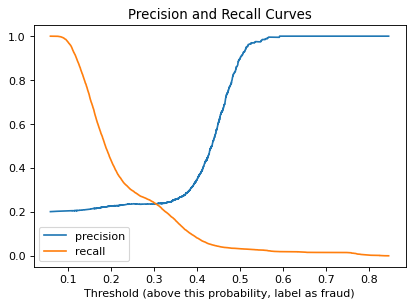

In [26]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_pred[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)')
plt.title('Precision and Recall Curves')

In [32]:
y_pred2 = y_pred[:,1]>0.3

print(f'Accuracy:\t{accuracy_score(y_test, y_pred2)}')
print(f'Precision:\t{precision_score(y_test, y_pred2, average="macro")}')
print(f'Recall:\t{recall_score(y_test, y_pred2, average="macro")}')
print(f'F1:\t{f1_score(y_test, y_pred2, average="macro")}')
confusion_matrix(y_test, y_pred2)

Accuracy:	0.69186
Precision:	0.5224424924588862
Recall:	0.522825
F1:	0.5226151458480693


array([[32182,  7818],
       [ 7589,  2411]])